<a href="https://colab.research.google.com/github/tal-yifat/deep-NLP-explainability/blob/main/Auxilary_task_injury_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# using ktrain https://github.com/amaiya/ktrain

In [ ]:
# Labels ("Contains") 
'NO VALUE FOUND': 1
'SHOULDERS': 2
'BACK': 3
'MULTIPLE PARTS':  4
'KNEE/PATELLA': 5
'FINGER\(S\)' : 6
All the rest: 0 

In [ ]:
%load_ext tensorboard

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  2 16:34:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    58W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/MSHA_Datasets


Mounted at /content/drive
/content/drive/MyDrive/MSHA_Datasets


In [ ]:
# The direct link to the shared dataset file is: https://drive.google.com/file/d/1CYKt6S-2BWAUbFai1BPGWb4Z5rZBNofk/view?usp=sharing
df = pd.read_csv('accidents_inj_label.csv')
print ('Total: {}'.format(df.shape[0]))
df = df.dropna(subset = ['text'])
print ('Total W/O NA: {}'.format(df.shape[0]))

df['text'] = df['text'].str.replace('EE', 'employee', case=True) # Tal
print(df['bp_label'].value_counts(normalize=True))




Total: 207641
Total W/O NA: 207641
0    0.432501
6    0.143873
3    0.127480
1    0.091109
5    0.075057
4    0.071417
2    0.058563
Name: bp_label, dtype: float64


In [ ]:
# TAKE SMALL AMOUNT OF DATA FOR CODE TESTING 
#df = df.head(10000)

In [ ]:
#df['NARRATIVE'] = df['INJ_BODY_PART'] + ' $$ ' + df['NARRATIVE']
#df['NARRATIVE'] = df['NATURE_INJURY'] + ' $$ ' + df['NARRATIVE']
#df['NARRATIVE'] = df['ACCIDENT_TYPE'] + ' $$ ' + df['NARRATIVE']

In [ ]:
df.head()

,text,bp_label
0,Employee says he slipped off back of fuel truc...,3
1,2 employees were attempting to load troughing ...,6
2,Employee was pushing against pry bar. Bar slip...,0
3,Employee tripped on c-channel at #6 silo. Fel...,5
4,Ground was icy. Employee slipped on ice and f...,2


In [ ]:
df.reset_index(drop=True, inplace=True)
df.rename(columns={'bp_label': 'label'}, inplace=True)
df.head()


,text,label
0,Employee says he slipped off back of fuel truc...,3
1,2 employees were attempting to load troughing ...,6
2,Employee was pushing against pry bar. Bar slip...,0
3,Employee tripped on c-channel at #6 silo. Fel...,5
4,Ground was icy. Employee slipped on ice and f...,2


In [ ]:
dftext = df.text.values
dflabels = df.label.values

In [ ]:
!pip install ktrain
import ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 9.3 MB/s 
     |████████████████████████████████| 981 kB 61.3 MB/s 
     |████████████████████████████████| 265 kB 85.4 MB/s 
     |████████████████████████████████| 3.8 MB 84.2 MB/s 
     |████████████████████████████████| 1.3 MB 80.0 MB/s 
     |████████████████████████████████| 468 kB 68.9 MB/s 
     |████████████████████████████████| 880 kB 80.7 MB/s 
     |████████████████████████████████| 182 kB 86.6 MB/s 
     |████████████████████████████████| 7.6 MB 47.5 MB/s 
  Created wheel for ktrain: filename=ktrain-0.32.3-py3-none-any.whl size=25313585 sha256=c3c73d9c04792c0e272b2a28c33fd43ff536d18be7e3944b4f113de55d58d114
  Stored in directory: /root/.cache/pip/wheels/c4/a0/4b/38365824295b72c59f340fce7927cdb5438d2705f5dbbe47b7
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=678a67f35ea017c74cbdec5b

In [ ]:
classes =  list(set(df.label))

In [ ]:
from sklearn.model_selection import train_test_split
from ktrain.text.data import texts_from_array
from ktrain.text import text_classifier
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.2, random_state=42)

trn, val, preproc = texts_from_array(x_train=X_train.values, y_train=y_train.values,
                                          x_test=None, y_test=None,
                                                                   class_names=classes,
                                                                   val_pct=0.1, 
                                                                   max_features=30000, 
                                                                   maxlen=256,
                                                                   preprocess_mode='bert',
                                                                   random_state=42,
                                                                   ngram_range=1)

# Model 
# metrics function names here https://www.tensorflow.org/api_docs/python/tf/keras/metrics#functions_2
# default is metrics=['accuracy']
model = text_classifier('bert', train_data=trn, preproc=preproc)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 256
done.


In [ ]:
import tensorflow
# Handling class imbalance
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping
tensorflow.config.run_functions_eagerly(True)

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(df.label),
                                                 y = y_train)
print(class_weights)

weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

print(weights)

# Applying the weights

learner =  ktrain.get_learner(model, train_data=trn, val_data=val,batch_size=32)

# find learning rate
#learner.lr_find(show_plot=True,max_epochs=5)

# run for 3 epochs
with tensorflow.device('/device:GPU:0'):
  learner.autofit(2e-5, 3,class_weight = weights,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# validate  result 
learner.validate()

# create predictor
predictor = ktrain.get_predictor(learner.model, preproc)

# Make predictions
print (predictor.predict("worker fell from roof and broke leg"))
print (predictor.predict("worker ate lunch and hurt finger"))


[0.3296972  1.57029418 2.46830515 1.1173503  2.00509385 1.89994281
 0.9951057 ]
{0: 0.32969720065418634, 1: 1.570294184375709, 2: 2.468305150227347, 3: 1.1173503020192916, 4: 2.0050938499607702, 5: 1.8999428113919707, 6: 0.9951057036224982}


begin training using triangular learning rate policy with max lr of 2e-05...


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/3
4672/4672 [==============================] - 2877s 615ms/step - loss: 0.5618 - accuracy: 0.7876 - val_loss: 0.4550 - val_accuracy: 0.8456
Epoch 2/3
4672/4672 [==============================] - 2845s 609ms/step - loss: 0.3876 - accuracy: 0.8506 - val_loss: 0.4458 - val_accuracy: 0.8490
Epoch 3/3
4672/4672 [==============================] - 2831s 606ms/step - loss: 0.3409 - accuracy: 0.8649 - val_loss: 0.4321 - val_accuracy: 0.8500


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


520/520 [==============================] - 144s 276ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      7234
           1       0.96      0.87      0.91      1496
           2       0.80      0.88      0.84       904
           3       0.89      0.88      0.88      2121
           4       0.43      0.78      0.55      1204
           5       0.86      0.93      0.89      1239
           6       0.90      0.95      0.93      2414

    accuracy                           0.85     16612
   macro avg       0.83      0.87      0.84     16612
weighted avg       0.88      0.85      0.86     16612



/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 296ms/step
0
1/1 [==============================] - 0s 291ms/step
6


In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
current_run_logs_dir='MSHA_logs'+"_"+timestr


In [ ]:
!mkdir $current_run_logs_dir

In [ ]:
predicted_labels_merged = predictor.predict(X_test.values)
predicted_proba_merged = predictor.predict_proba(X_test.values)
true_labels_merged = y_test

1298/1298 [==============================] - 363s 279ms/step


In [ ]:
aucpath = "/content/drive/MyDrive/MSHA_Datasets/"+current_run_logs_dir+"/auc_roc_plot.png"
clpath = "/content/drive/MyDrive/MSHA_Datasets/"+current_run_logs_dir+"/classification_report.png"
cmpath = "/content/drive/MyDrive/MSHA_Datasets/"+current_run_logs_dir+"/confussion_matrix.png"


In [ ]:
!pip install dataframe_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt install chromium-chromedriver


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 95.6 MB of archives.
After this operation, 321 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 108.0.5359.71-0ubuntu0.18.04.5 [1,159 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 108.0.5359.71-0ubuntu0.18

In [ ]:
print(classification_report(true_labels_merged,predicted_labels_merged))
print(confusion_matrix(true_labels_merged,predicted_labels_merged))

#%%polaroid_camera --path $cmpath
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import dataframe_image as dfi

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     17829
           1       0.96      0.87      0.91      3806
           2       0.82      0.87      0.84      2546
           3       0.88      0.88      0.88      5232
           4       0.43      0.75      0.54      2994
           5       0.85      0.93      0.89      3095
           6       0.89      0.96      0.92      6027

    accuracy                           0.85     41529
   macro avg       0.83      0.87      0.84     41529
weighted avg       0.88      0.85      0.86     41529

[[14301    75   233   228  2090   282   620]
 [  124  3301    41    92   133    57    58]
 [   40     6  2218    60   185    33     4]
 [   62    14    61  4597   453    36     9]
 [  304    29   140   186  2241    79    15]
 [   57     5    14    25   121  2873     0]
 [  177     3     7    16    37     7  5780]]


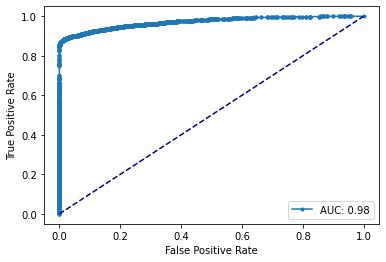

In [ ]:
#%%polaroid_camera --path $aucpath

auc = roc_auc_score(true_labels_merged,predicted_proba_merged, multi_class='ovr')
auc=round(auc,2)

from sklearn.metrics import roc_curve
from matplotlib import pyplot
br_fpr, br_tpr, _ = roc_curve(true_labels_merged, predicted_proba_merged[:,1], pos_label=1)
# plot the roc curve for the model
pyplot.plot(br_fpr, br_tpr, marker='.', label=('AUC: %.2f' % auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
# show the plot
plt.savefig(aucpath)
pyplot.show()


In [ ]:
clreport = classification_report(true_labels_merged,predicted_labels_merged, output_dict=True)
df = pd.DataFrame(clreport).transpose()
dfi.export(df, clpath)
cmreport = confusion_matrix(true_labels_merged,predicted_labels_merged)
#df = pd.DataFrame(cmreport).transpose()
df = pd.DataFrame(cmreport)
dfi.export(df, cmpath)

In [ ]:
model_save_name = 'bert_injuries_model_kt_Inj_Label.pt'
path =F"/content/drive/MyDrive/MSHA_Datasets/" + current_run_logs_dir + "/" + model_save_name
predictor.save(path)

In [ ]:
nb_path = "/content/drive/MyDrive/MSHA_Datasets/"+current_run_logs_dir+"/Saved_Bert_Injuries_kt_Inj_Label.ipynb"
%notebook $nb_path

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/MSHA_Datasets

Mounted at /content/drive
/content/drive/MyDrive/MSHA_Datasets


In [ ]:
!pip install ktrain
import ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.5 MB/s 
     |████████████████████████████████| 981 kB 54.7 MB/s 
     |████████████████████████████████| 265 kB 71.7 MB/s 
     |████████████████████████████████| 3.8 MB 63.7 MB/s 
     |████████████████████████████████| 1.3 MB 64.8 MB/s 
     |████████████████████████████████| 468 kB 67.8 MB/s 
     |████████████████████████████████| 880 kB 63.5 MB/s 
     |████████████████████████████████| 182 kB 58.0 MB/s 
     |████████████████████████████████| 7.6 MB 59.4 MB/s 
  Created wheel for ktrain: filename=ktrain-0.32.3-py3-none-any.whl size=25313585 sha256=fe1f774452bb8e05d92988c46df6efba36b593cbd7a2b0193267b94a2ae093e9
  Stored in directory: /root/.cache/pip/wheels/c4/a0/4b/38365824295b72c59f340fce7927cdb5438d2705f5dbbe47b7
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=084e1f133877a16caa724820

In [ ]:
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 6.9 MB 5.7 MB/s
     |████████████████████████████████| 133 kB 25.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107983 sha256=45541140f18b070186db07b5ee4ae88932380075370d68b1b8250fe733bee68d
  Stored in directory: /tmp/pip-ephem-wheel-cache-wdwns8f1/wheels/8a/62/28/7afdf7a1b0dd10105ae02d5b29f683bc72921d91ce399925eb
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
model_save_name = 'bert_injuries_model_kt_Inj_Label.pt'
current_run_logs_dir = 'MSHA_logs_20230102-190233'
path =F"/content/drive/MyDrive/MSHA_Datasets/" + current_run_logs_dir + "/" + model_save_name

predictor = ktrain.load_predictor(path)
model = ktrain.get_predictor(predictor.model, predictor.preproc)
predictions = model.predict('worker broke leg')
print (predictions)

1/1 [==============================] - 9s 9s/step
0


In [ ]:
!pip install Ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 26.9 MB/s 


In [ ]:
from IPython.display import display
print('----------------------------------')
display(model.explain('worker broke leg and called employer'))
print('----------------------------------')
display(model.explain('worker ate lunch and cut finger'))


----------------------------------
79/79 [==============================] - 47s 594ms/step


----------------------------------
79/79 [==============================] - 48s 614ms/step
